# Final Project - Competition for the performance


Name: Su Minghui</br>
Student ID: 2101212923

## 1. Data pre-processing

### Basic packages importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline

### Data preparation

In [ ]:
#Importing the training and testing dataset
train_dataset = pd.read_csv('training.csv') #238,836 samples in the training dataset
test_dataset = pd.read_csv('test.csv') #59,709 samples in the testing dataset
train_dataset.dtypes #The datatypes in test dataset is the same as the train dataset

event      int64
var1     float64
var2     float64
var3     float64
var4     float64
var5     float64
var6     float64
var7     float64
var8     float64
split     object
id         int64
dtype: object



*   The variable *id* should be object type. 
*   To reduce the memory size, I convert the dtype of variable *event* from int64 into int8 type.




In [ ]:
#Convert dtype
train_dataset['event'] = train_dataset['event'].astype('int8')
test_dataset['event'] = test_dataset['event'].astype('int8')
train_dataset['id'] = train_dataset['id'].astype('object')
test_dataset['id'] = test_dataset['id'].astype('object')

Firsly, I check the ratio of missing values in the train and test data set. And the results show that I should handle the missing values before predicting.
Additionally, I find that the missing values ratio in train and test dataset are extremely similar.

In [ ]:
#The ratio of missing values in the training dataset is quite high
#So we need figure how to handle the missing values
print(train_dataset.isnull().sum() / train_dataset.shape[0])
print('---------------')
print(test_dataset.isnull().sum() / test_dataset.shape[0])

event    0.000000
var1     0.442982
var2     0.509973
var3     0.804732
var4     0.672633
var5     0.965303
var6     0.975134
var7     0.884682
var8     0.576500
split    0.000000
id       0.000000
dtype: float64
---------------
event    0.000000
var1     0.440302
var2     0.507629
var3     0.806880
var4     0.675794
var5     0.964746
var6     0.974510
var7     0.885729
var8     0.577099
split    0.000000
id       0.000000
dtype: float64


<Axes: >

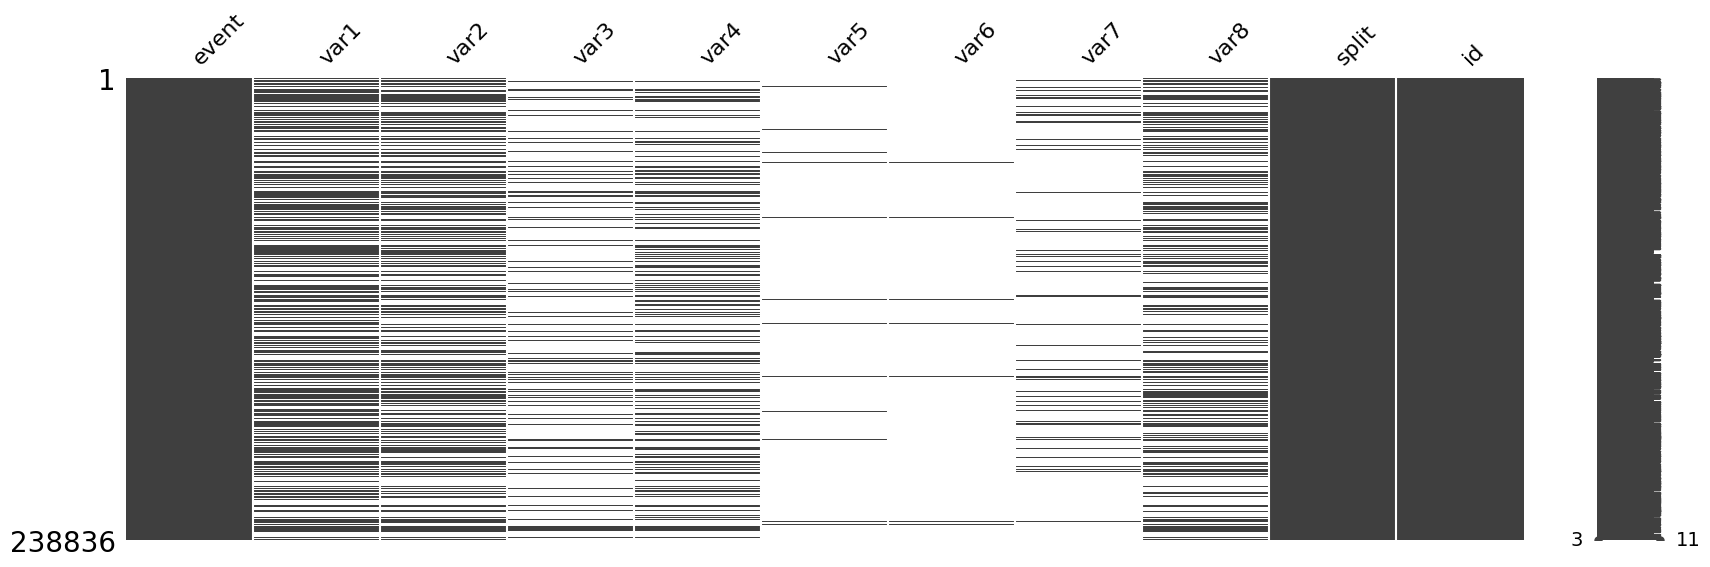

In [ ]:
#To show the missing value distribution
mno.matrix(train_dataset, figsize = (20, 6))

It can be seen that there are many observations where all the feature variables are missing. Such samples actually do not contain any information that can help with prediction, so I have deleted these observations from both the training and prediction sets.


*   There are 35.51% of oberservations in the train dataset are dropped because all feature varibales are missing.
*   There are 35.50% of oberservations in the test dataset are dropped for the same reason.



In [ ]:
#To check how many observations that all features are null
print(train_dataset[train_dataset[['var1', 'var2', 'var3', 'var4', 
                             'var5', 'var6', 'var7', 'var8']].isnull().all(axis=1)].shape[0]/train_dataset.shape[0])
print(test_dataset[test_dataset[['var1', 'var2', 'var3', 'var4', 
                             'var5', 'var6', 'var7', 'var8']].isnull().all(axis=1)].shape[0]/test_dataset.shape[0])

#Delete the observations that all features are null
train_dataset = train_dataset.dropna(axis=0, thresh=4)
test_dataset = test_dataset.dropna(axis=0, thresh=4)

0.3550762866569529
0.3550218560016078


The variable named *spilt* contain no information for the prediction. To make the analysis and coding more concise and simple, I drop it.

In [ ]:
#drop the variable named spilt
train_dataset = train_dataset.drop('split', axis=1)
train_dataset.reset_index(drop=True, inplace=True)
test_dataset = test_dataset.drop('split', axis=1)
test_dataset.reset_index(drop=True, inplace=True)

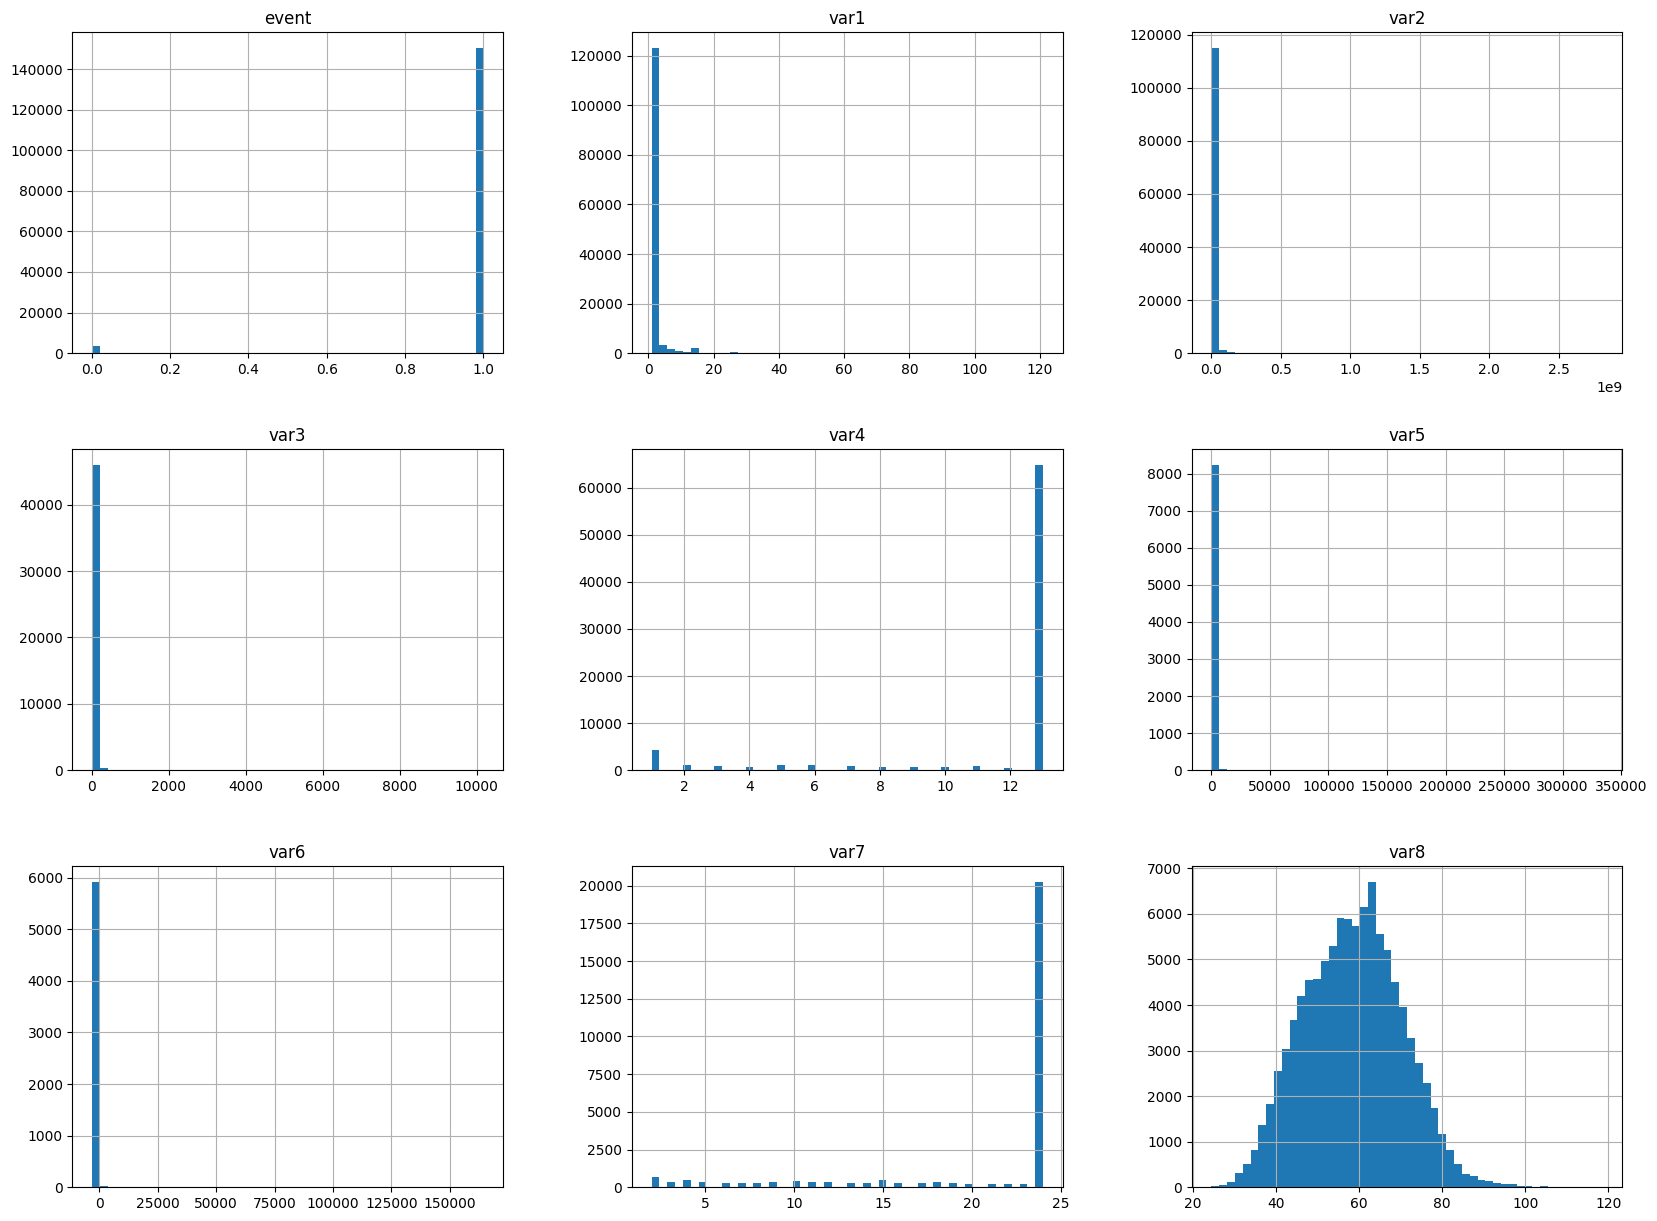

In [ ]:
#show the histgram of train dataset
train_dataset.hist(bins=50, figsize=(20,15))
plt.show()

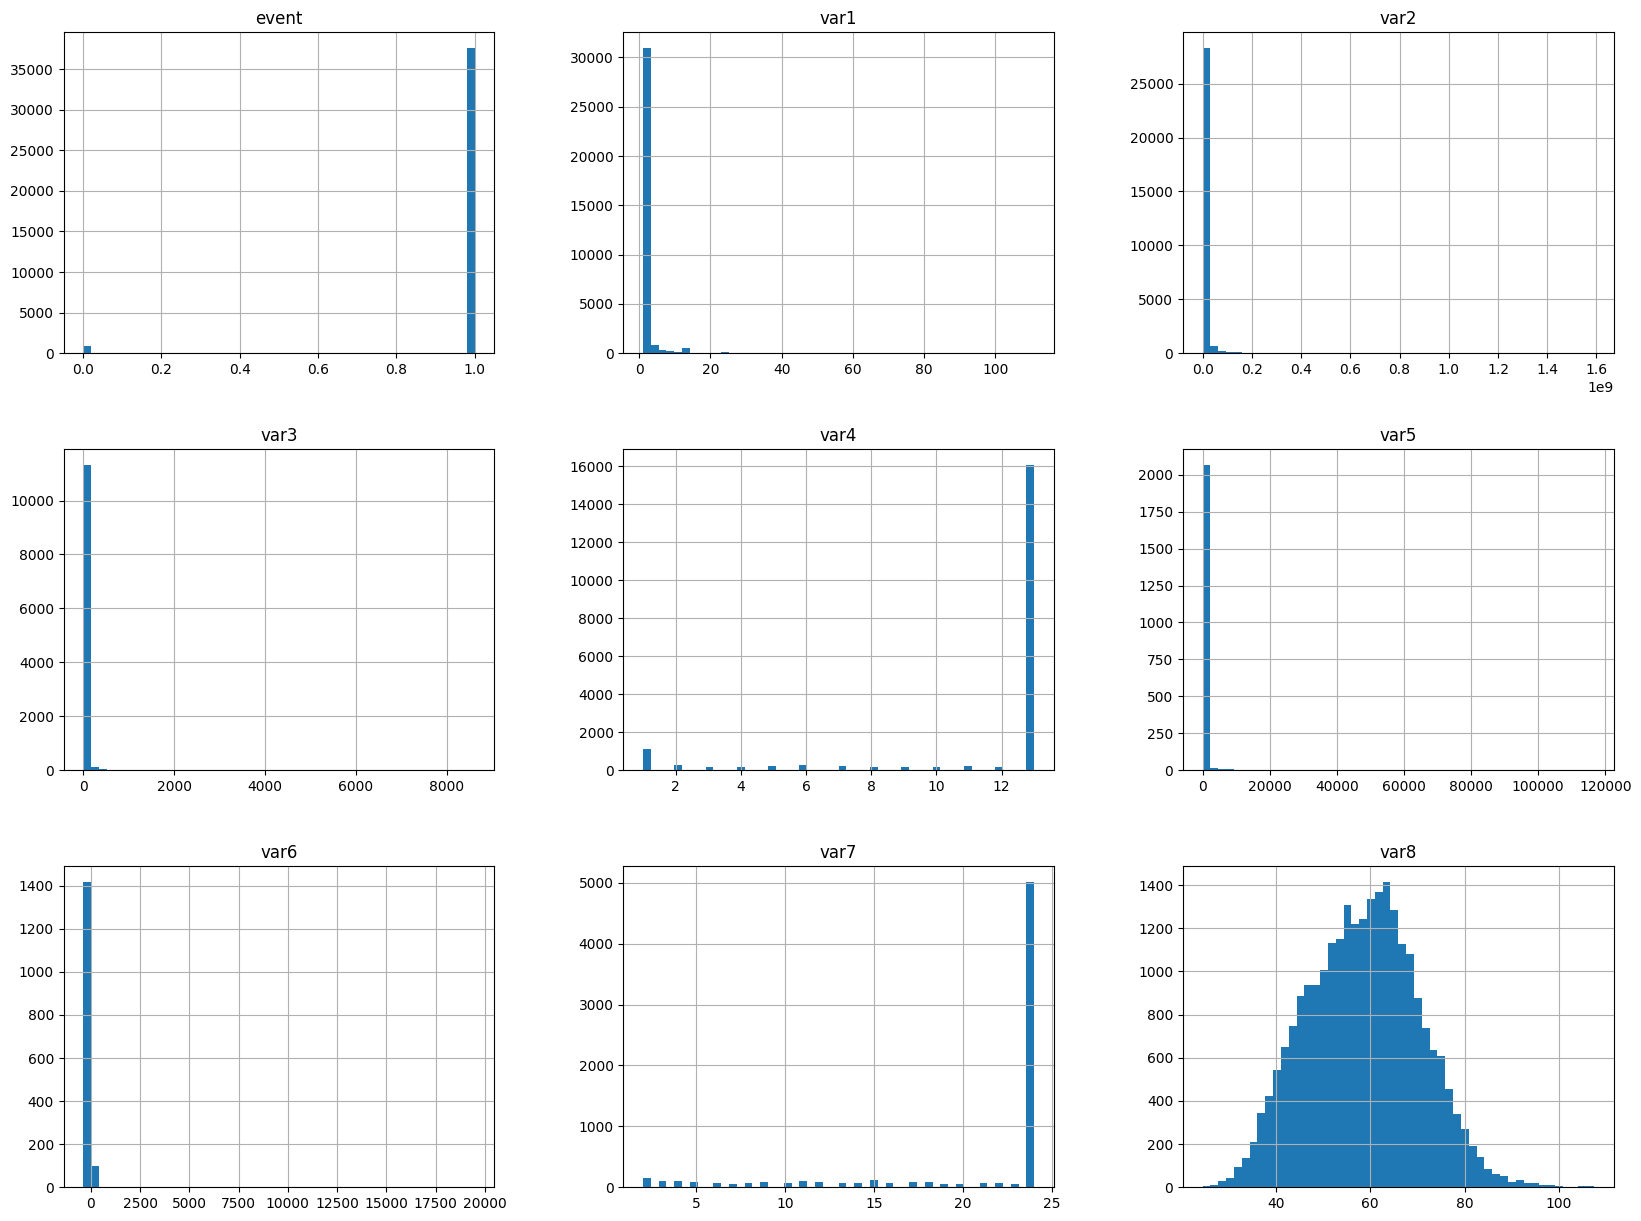

In [ ]:
#show the histgram of test dataset
test_dataset.hist(bins=50, figsize=(20,15))
plt.show()

The above description shows that: <br> 
*  The distribution of target variable and var 1 to var 7 in the train dataset are extremely imbalanced
*  Var8 follows the normal distribution
*  Features have lots of missing values

### Handling the missing values

The missing values would be treated with three ways: <br> 
*  Imputation using Regression
*  Imputation using Maximum Likelihood



1.  *Imputation using regression* 



The essence of imputation using regression model is to use other features to fit and impute one specific variable with missing values iteratively.


*   Advantages: This approach avoids the overestimation or underestimation problem caused by using central dependency measures such as mean or median, mode, etc. to fill in the missing values, while fully utilizing the interrelationships between the different features in the sample. In addition, the regression model is simple enough and efficient enough.


*   Disadvantages: The fact that this model reduce the inherent variability in the imputed variable is a significant drawback of this strategy. In other words, the predicted values lie in the regression hyperplane where the variable would have actually had some noise or bias because we replace the missing data with regression outputs.



In [ ]:
#To make a copy of dataset and identify the missing columns
train_dataset_hmv1 = train_dataset.copy()
test_dataset_hmv1 = test_dataset.copy()
missing_columns = ['var1', 'var2', 'var3', 'var4', 
                             'var5', 'var6', 'var7', 'var8']

To avoid this Catch-22 situation, this method initially impute the missing data with random observed values of the variable which is later followed by Regression Imputation of each of the variables iteratively. 

In [ ]:
#Author: https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression/notebook

#Random imputation function

def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [ ]:
#Imputation using regression function

def regression_imputation(df):

    for feature in missing_columns:
        df[feature + '_imp'] = df[feature]
        df = random_imputation(df, feature)
    
    deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

    for feature in missing_columns:
            
        deter_data["Det" + feature] = df[feature + "_imp"]
        parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
        
        #Create a Linear Regression model to estimate the missing data
        model = linear_model.LinearRegression()
        model.fit(X = df[parameters], y = df[feature + '_imp'])
        
        #observe that I preserve the index of the missing data from the original dataframe
        deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

<Axes: >

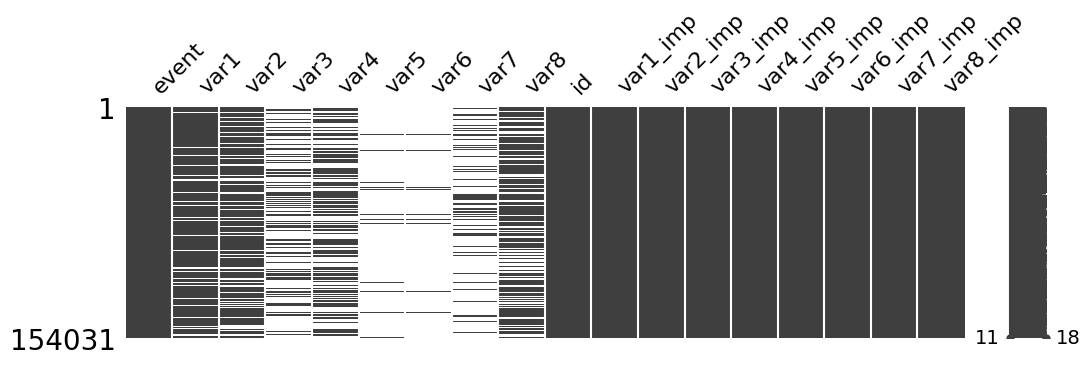

In [ ]:
#Impute the train dataset
regression_imputation(train_dataset_hmv1)
mno.matrix(train_dataset_hmv1, figsize = (12, 3))

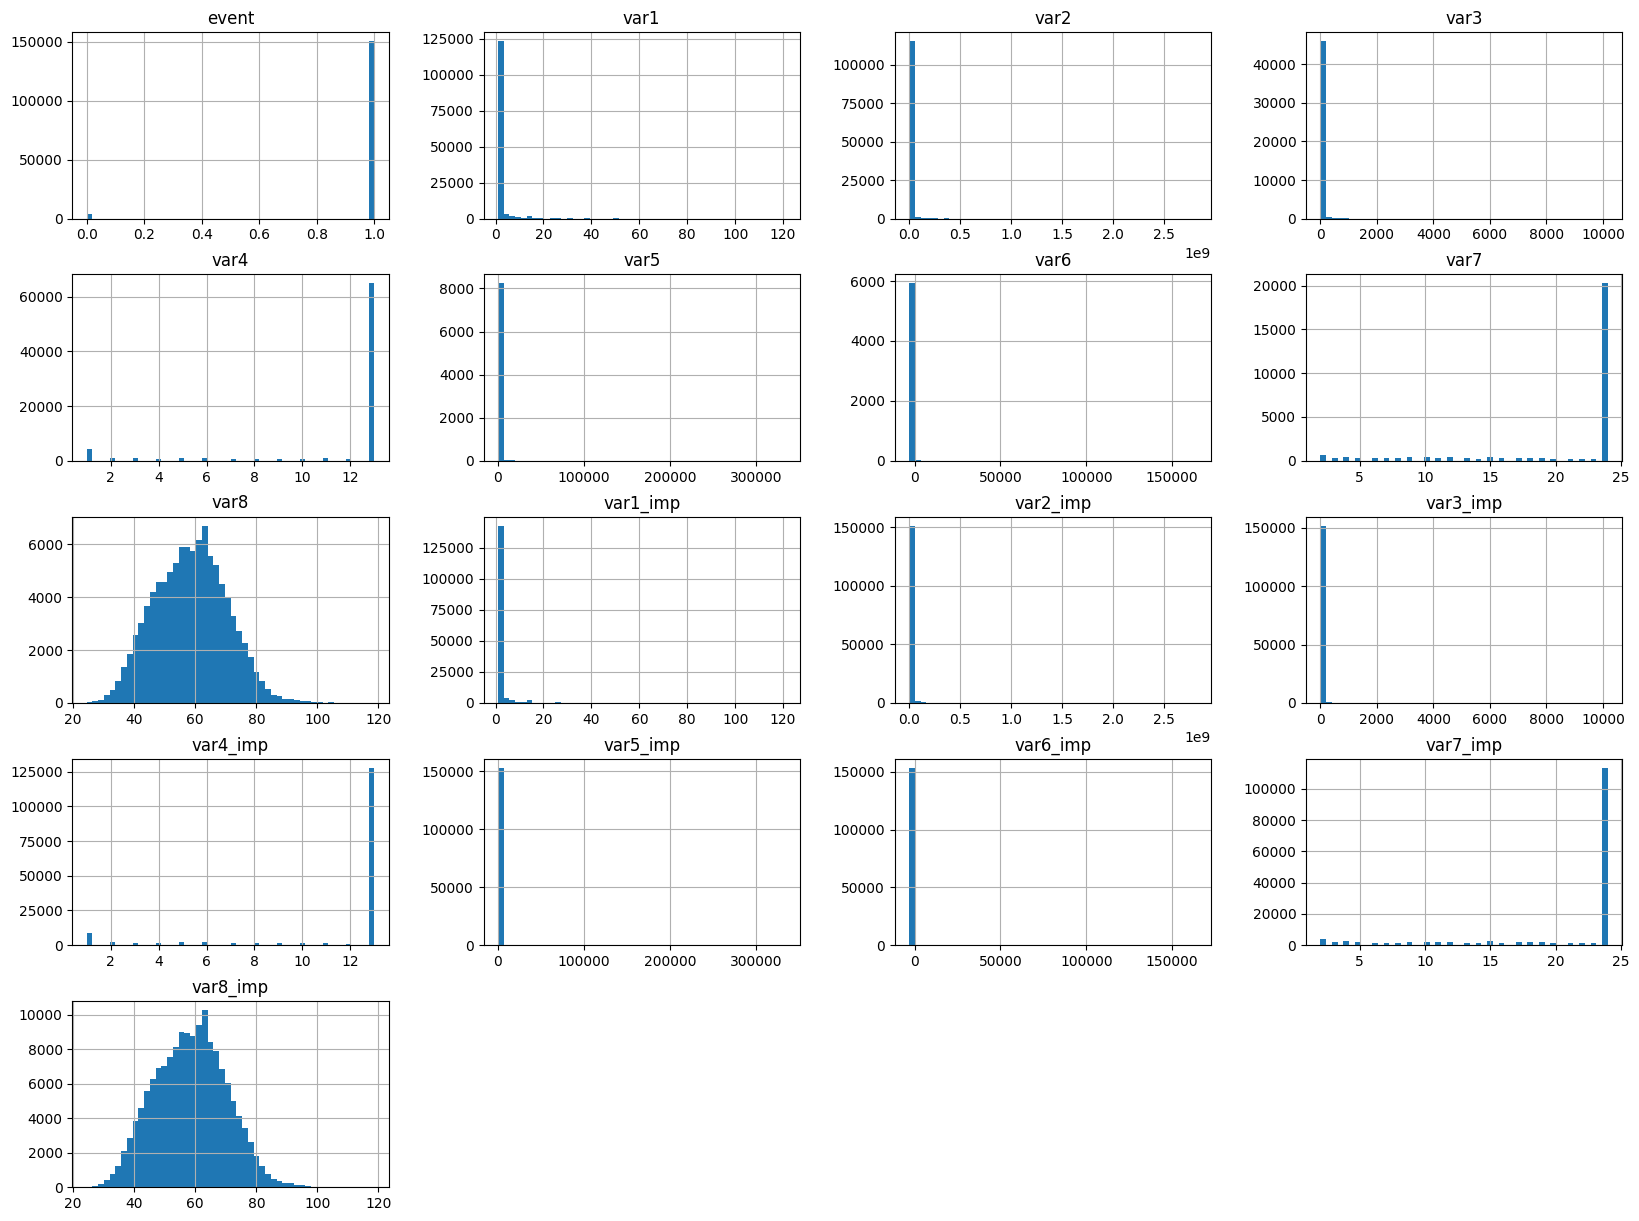

In [ ]:
#The regression impuation does not obviously change the distribution of variables
train_dataset_hmv1.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: >

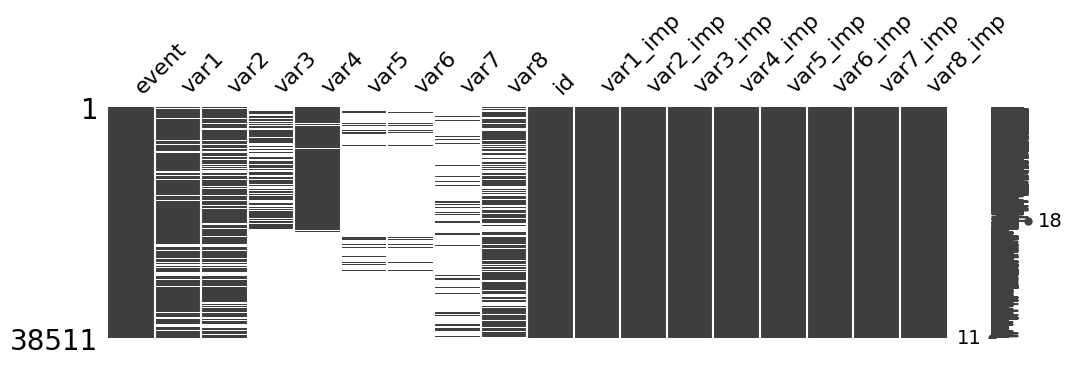

In [ ]:
#Impute the test dataset
regression_imputation(test_dataset_hmv1)
mno.matrix(test_dataset_hmv1, figsize = (12, 3))

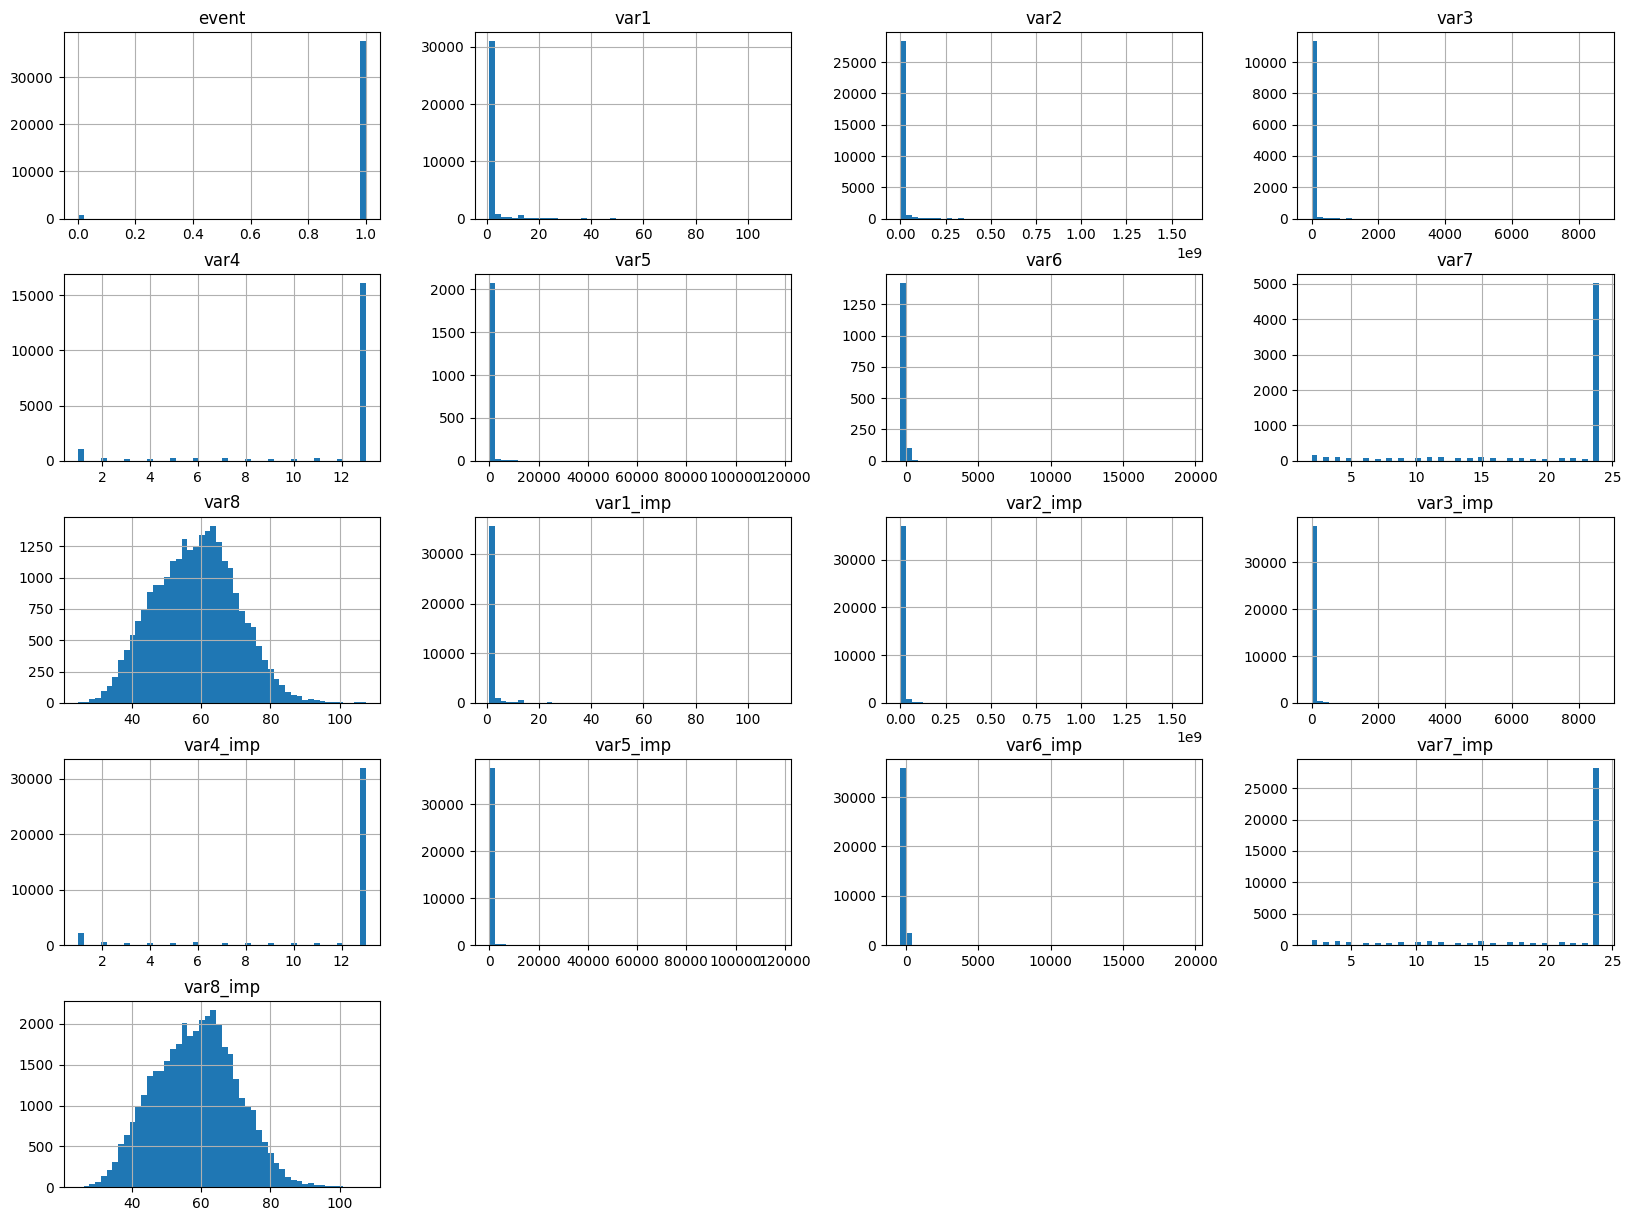

In [ ]:
#The regression impuation does not obviously change the distribution of variables
test_dataset_hmv1.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
#Extract targets and features based on this method

#For training
X1_train = train_dataset_hmv1.iloc[:,10:18] 
y1_train = train_dataset_hmv1.iloc[:,0]
#For testing
X1_test = test_dataset_hmv1.iloc[:,10:18] 
y1_test = test_dataset_hmv1.iloc[:,0]

##Standardizing the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X1_train)
X1_train_std = sc.transform(X1_train)
X1_test_std = sc.transform(X1_test)

*Oversampling*

*   To deal with the imbalanced issuse in the targets, I adopt the most naive strategy which is oversampling by randomly sampling with replacement the current available samples.
The advantage of oversampling in this case is that the implentation of undersampling reduces the observations from about 15,000 to about 5,000 in train dataset.

*   It should be noticed that the method to deal with the imbalanced issue has pitfall: the model will not be tested on a dataset with class distribution similar to the real use-case. Indeed, by resampling the entire dataset.
*   And the final dataset combination for the first imputation method is train - (X1_train_os, y1_train_os) and test - (X1_test_os, y1_test_os).

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X1_train_os, y1_train_os = ros.fit_resample(X1_train_std, y1_train)
X1_test_os, y1_test_os = ros.fit_resample(X1_test_std, y1_test)

*The correlation between features*

In order to avoid problems that may arise during feature selection or prediction due to strong correlations between variables, a correlation test was conducted. It can be observed that there is no particularly strong correlation between variables. 

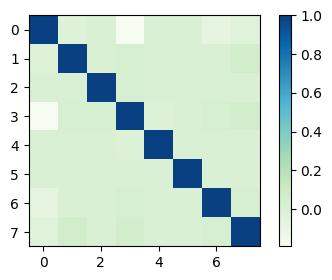

In [39]:
corr_matrix = np.corrcoef(X1_train_os.T)
plt.figure(figsize=(5, 3))
plt.imshow(corr_matrix, cmap='GnBu', interpolation='nearest')
plt.colorbar()
plt.show()

2.   *Multiple Imputation* 

Multiple imputation fills in missing values by generating plausible numbers derived from distributions of and relationships among observed variables in the data set. 

Multiple imputation entails two stages: 1) generating replacement values (“imputations”) for missing data and repeating this procedure many times, resulting in many data sets with replaced missing information, and 2) analyzing the many imputed data sets and combining the results.

In [ ]:
train_dataset_2 = train_dataset.copy()
test_dataset_2 = test_dataset.copy()

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mp_mean = IterativeImputer(random_state=0, sample_posterior=True)
train_dataset_hmv2_np = mp_mean.fit_transform(train_dataset_2)
test_dataset_hmv2_np = mp_mean.fit_transform(test_dataset_2)

In [ ]:
train_dataset_hmv2 = pd.DataFrame(train_dataset_hmv2_np, columns=train_dataset.columns)
test_dataset_hmv2 = pd.DataFrame(test_dataset_hmv2_np, columns=test_dataset.columns)
train_dataset_hmv2['id'] = train_dataset_hmv2['id'].astype('object')
test_dataset_hmv2['id'] = test_dataset_hmv2['id'].astype('object')

<Axes: >

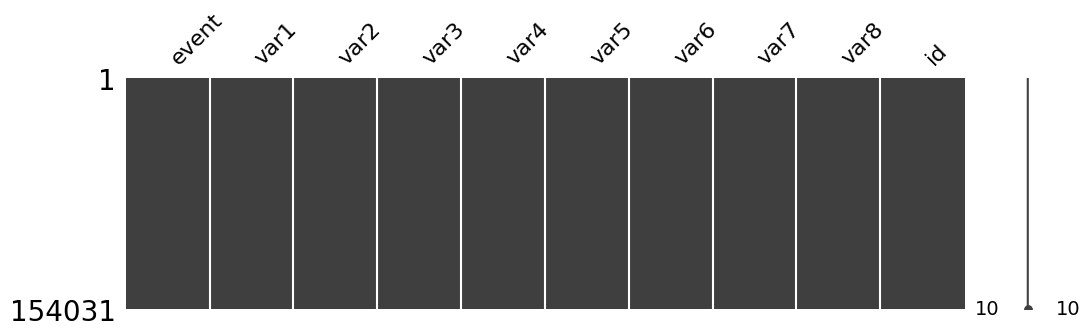

In [ ]:
#Show the imputation results for train dataset
mno.matrix(train_dataset_hmv2, figsize = (12, 3))

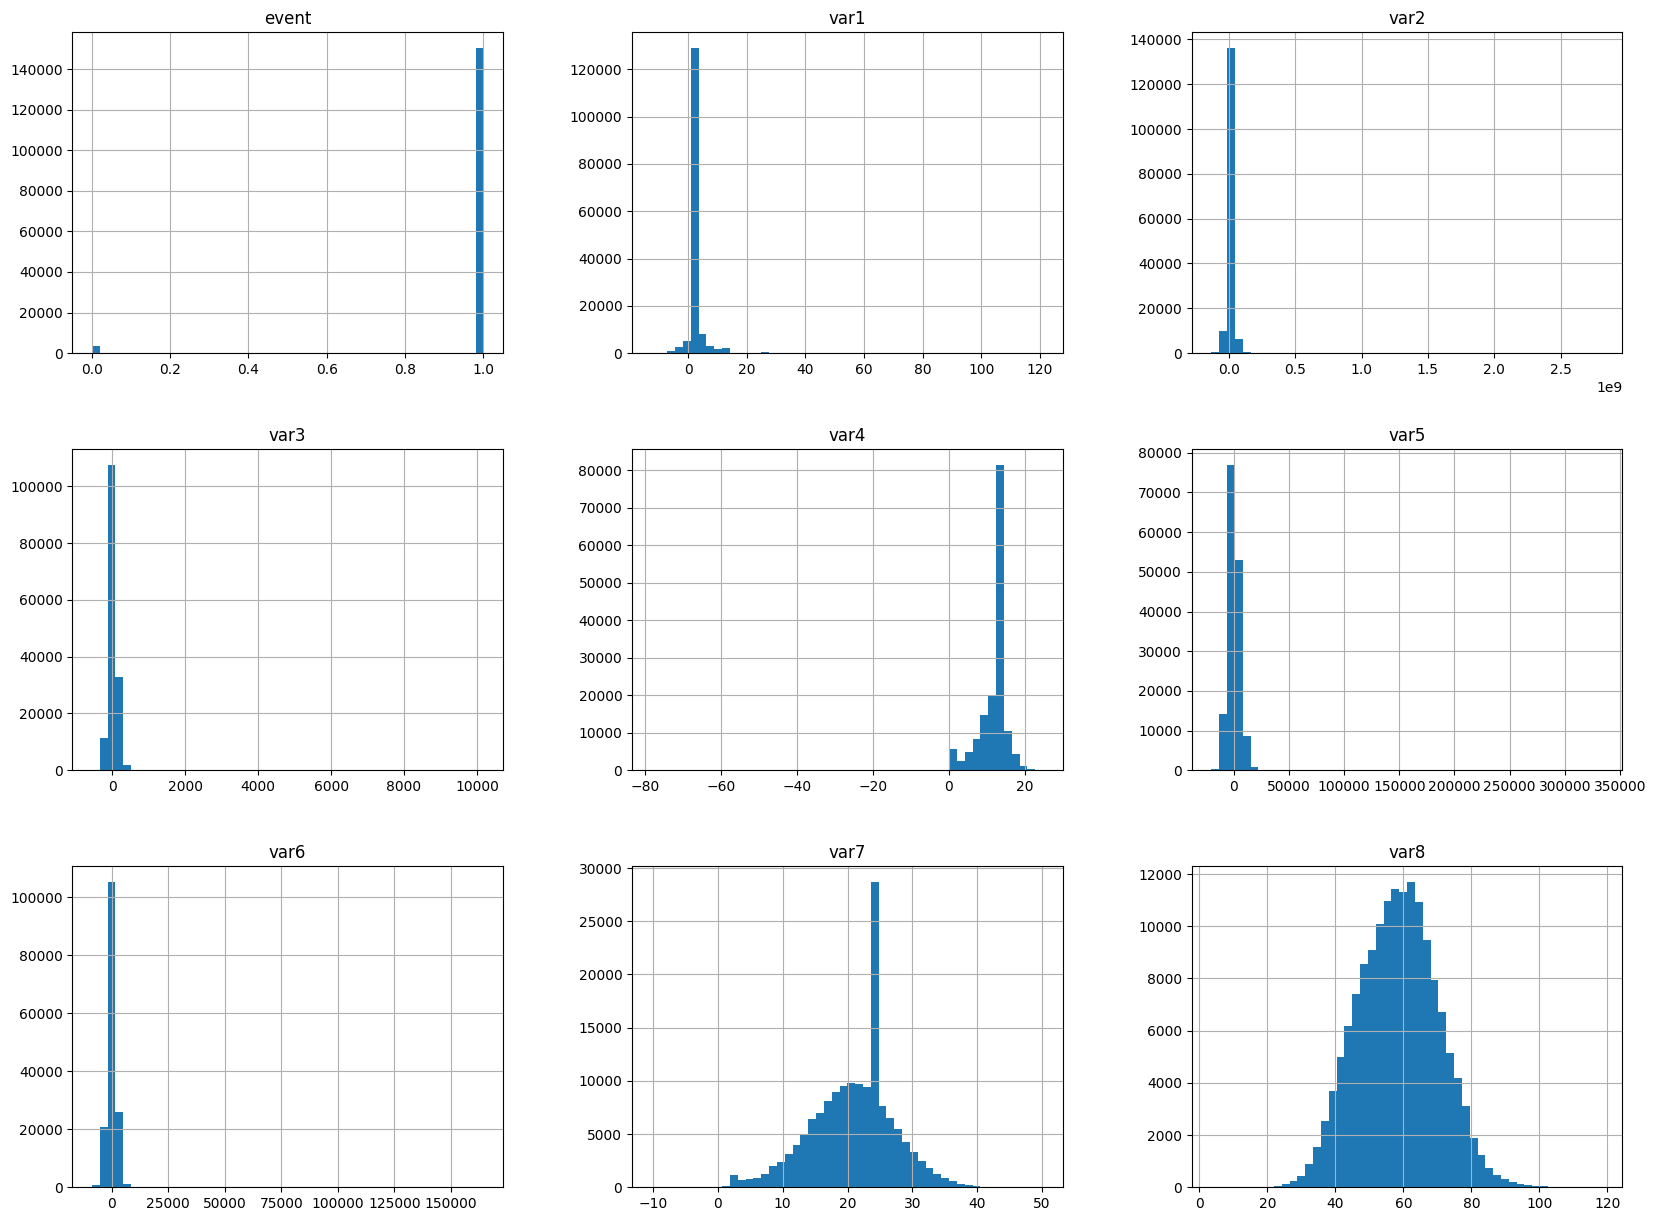

In [ ]:
#Show the imputation results for train dataset
train_dataset_hmv2.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: >

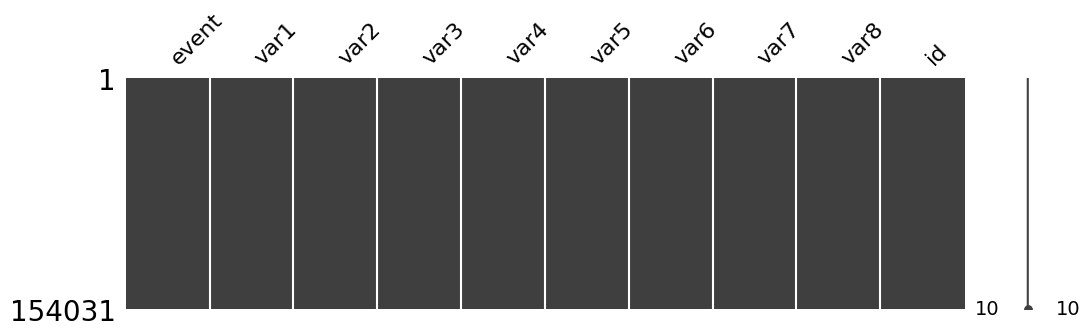

In [ ]:
#Show the imputation results for test dataset
mno.matrix(train_dataset_hmv2, figsize = (12, 3))

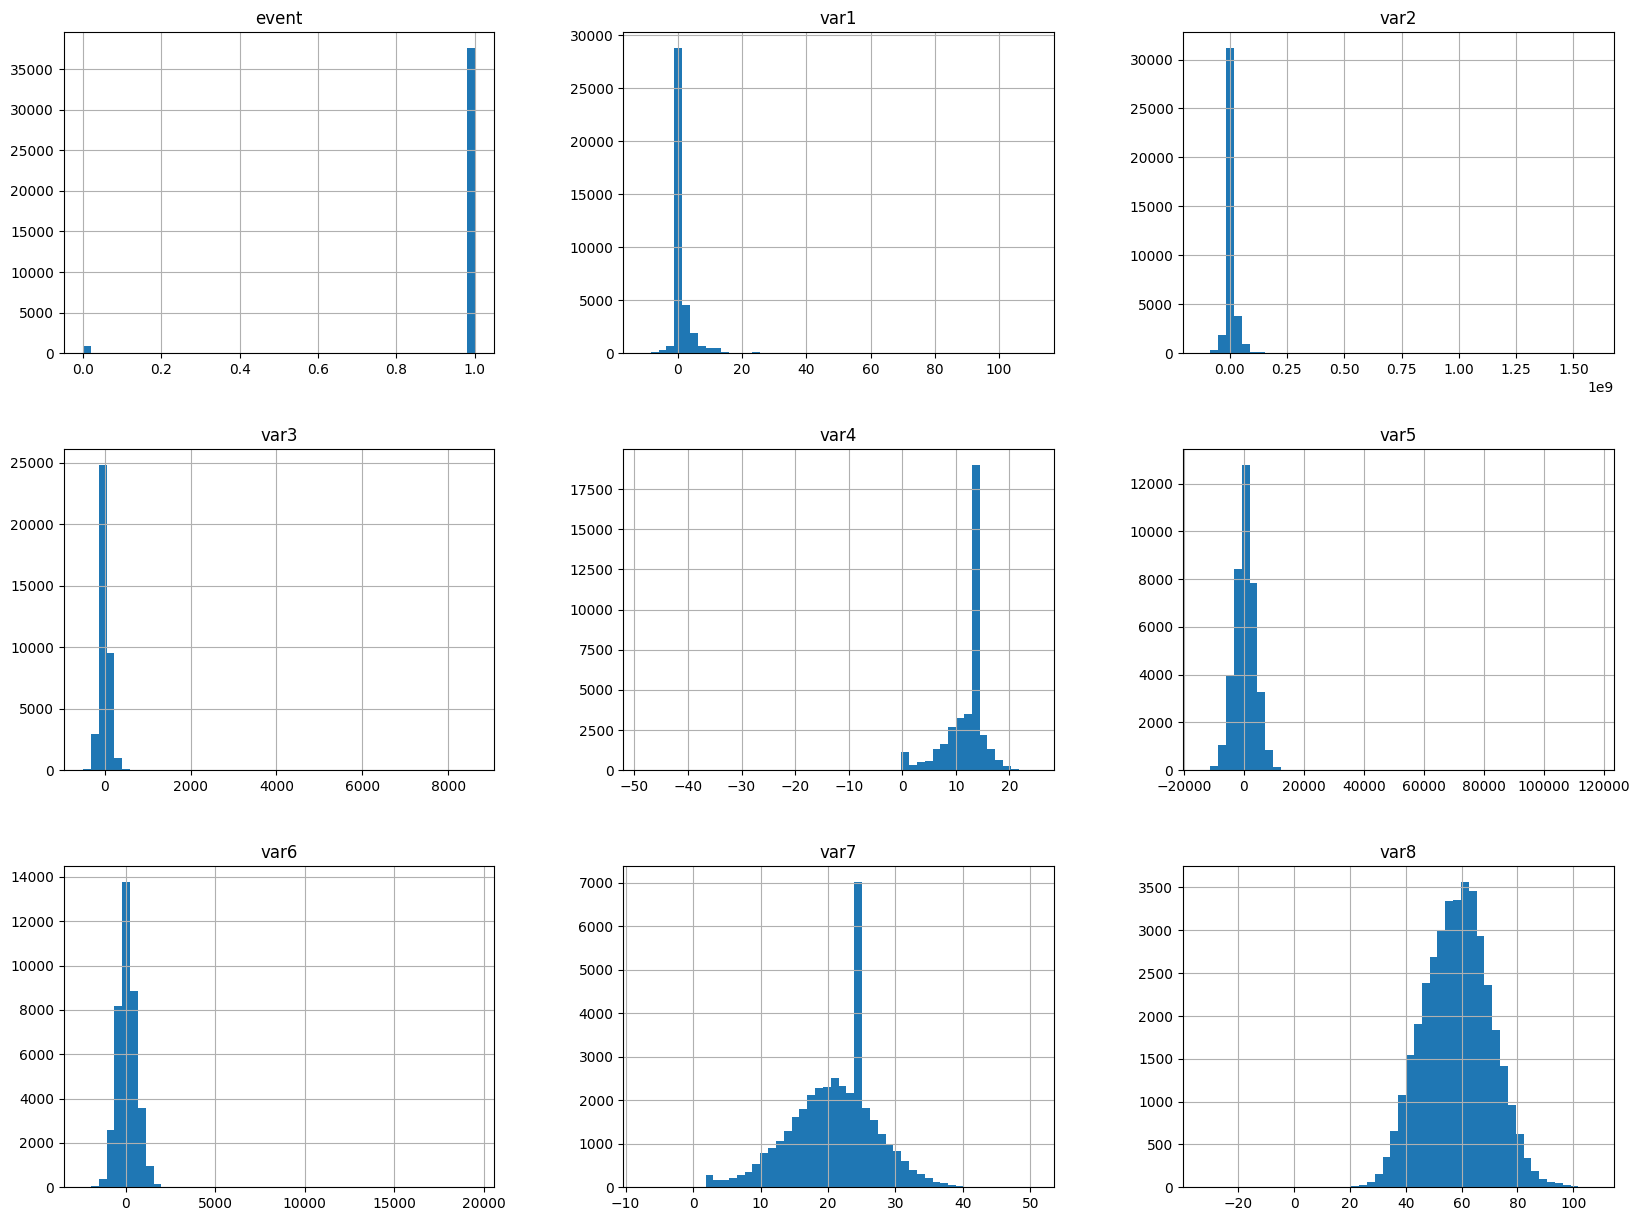

In [ ]:
#Show the imputation results for test dataset
test_dataset_hmv2.hist(bins=50, figsize=(20,15))
plt.show()

It can be observed that multiple imputation make the distribution of filled variables approach to normal distribution, which is very different from using regression model to impute.

In [ ]:
#Extract targets and features based on this method

#For training
X2_train = train_dataset_hmv2.iloc[:,1:9] 
y2_train = train_dataset_hmv2.iloc[:,0]
#For testing
X2_test = test_dataset_hmv2.iloc[:,1:9] 
y2_test = test_dataset_hmv2.iloc[:,0]

#Standardizing the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X2_train)
X2_train_std = sc.transform(X2_train)
X2_test_std = sc.transform(X2_test)

#Oversampling like before
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X2_train_os, y2_train_os = ros.fit_resample(X2_train_std, y2_train)
X2_test_os, y2_test_os = ros.fit_resample(X2_test_std, y2_test)

And the final dataset combination for the second imputation method is train - (X2_train_os, y2_train_os) and test - (X2_test_os, y2_test_os).

*The correlation between features*

It can be seen that the multiple imputation method has improved the correlation between certain variables, which needs to be paid special attention to in subsequent predictions.

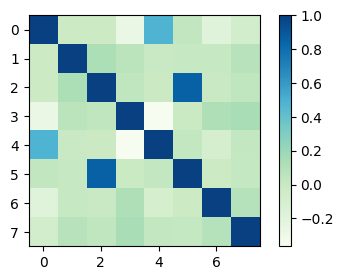

In [40]:
corr_matrix_2 = np.corrcoef(X2_train_os.T)
plt.figure(figsize=(5, 3))
plt.imshow(corr_matrix_2, cmap='GnBu', interpolation='nearest')
plt.colorbar()
plt.show()

## 2. Feature selection

### Principal Component Analysis

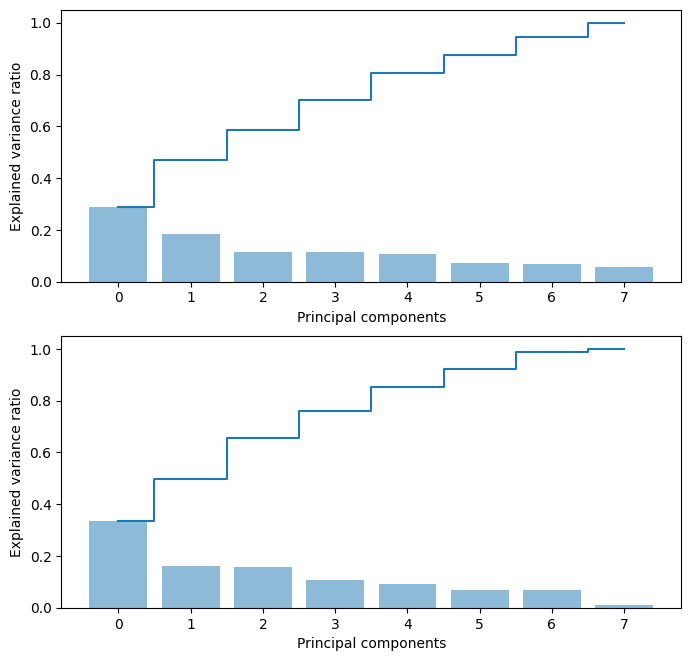

In [43]:
from sklearn.decomposition import PCA

#The train-test combination one
pca = PCA()
X1_train_pca = pca.fit_transform(X1_train_os)
pca.explained_variance_ratio_

#Create a figure object with 3 rows and 1 column
fig = plt.figure(figsize=(8, 12))

#Add the first subplot to the figure
ax1 = fig.add_subplot(311)
ax1.bar(range(8), pca.explained_variance_ratio_, alpha=0.5, align='center')
ax1.step(range(8), np.cumsum(pca.explained_variance_ratio_), where='mid')
ax1.set_ylabel('Explained variance ratio')
ax1.set_xlabel('Principal components')
ax1.set_xticks(range(8))

pca = PCA(n_components=3)
X1_train_pca = pca.fit_transform(X1_train_os)
X1_test_pca = pca.transform(X1_test_os)

#The train-test combination two
pca = PCA()
X2_train_pca = pca.fit_transform(X2_train_os)
pca.explained_variance_ratio_

#Add the second subplot to the figure
ax2 = fig.add_subplot(312)
ax2.bar(range(8), pca.explained_variance_ratio_, alpha=0.5, align='center')
ax2.step(range(8), np.cumsum(pca.explained_variance_ratio_), where='mid')
ax2.set_ylabel('Explained variance ratio')
ax2.set_xlabel('Principal components')
ax2.set_xticks(range(8))

pca = PCA(n_components=3)
X2_train_pca = pca.fit_transform(X2_train_os)
X2_test_pca = pca.transform(X2_test_os)

#Show the figure
plt.show()

With the principal component analysis, the train and test combination are:
*   Regression imputation: (X1_train_pca, y1_train_os) \ (X1_test_pca, y1_test_os)
*   Multiple imputation: (X2_train_pca, y2_train_os) \ (X2_test_pca, y2_test_os)


### Logistic Regression with L1 regularization

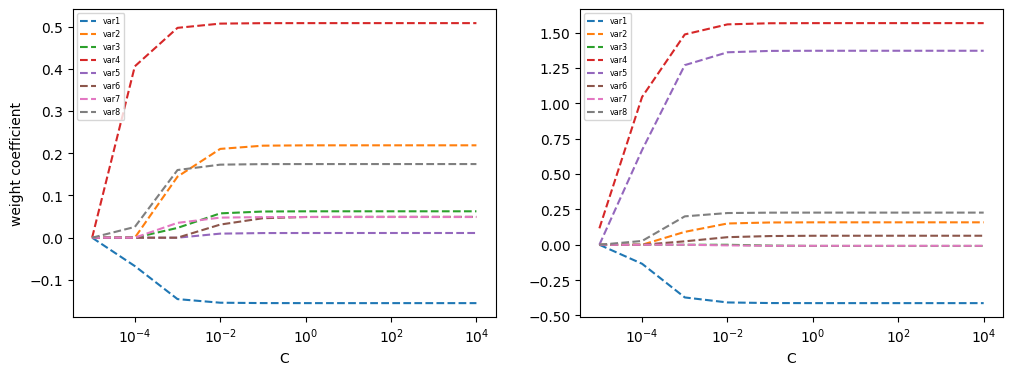

In [42]:
#L1 penalty - solver='liblinear'
from sklearn.linear_model import LogisticRegression
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#The train-test combination one
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1,
                            solver='liblinear',
                            multi_class='ovr',
                            penalty='l1')
    lr.fit(X1_train_os, y1_train_os)
    weights.append(lr.coef_[0])
    params.append(10.**c)
    
weights = np.array(weights)
ax1.plot(params, weights[:, 0], linestyle='--',
         label='var1')
ax1.plot(params, weights[:, 1], linestyle='--',
         label='var2')
ax1.plot(params, weights[:, 2], linestyle='--',
         label='var3')
ax1.plot(params, weights[:, 3], linestyle='--',
         label='var4')
ax1.plot(params, weights[:, 4], linestyle='--',
         label='var5')
ax1.plot(params, weights[:, 5], linestyle='--',
         label='var6')
ax1.plot(params, weights[:, 6], linestyle='--',
         label='var7')
ax1.plot(params, weights[:, 7], linestyle='--',
         label='var8')

ax1.set_ylabel('weight coefficient')
ax1.set_xlabel('C')
ax1.legend(loc='best', fontsize='xx-small')
ax1.set_xscale('log')

#The train-test combination two
from sklearn.linear_model import LogisticRegression

weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1,
                            solver='liblinear',
                            multi_class='ovr',
                            penalty='l1')
    lr.fit(X2_train_os, y2_train_os)
    weights.append(lr.coef_[0])
    params.append(10.**c)
    
weights = np.array(weights)
ax2.plot(params, weights[:, 0], linestyle='--',
         label='var1')
ax2.plot(params, weights[:, 1], linestyle='--',
         label='var2')
ax2.plot(params, weights[:, 2], linestyle='--',
         label='var3')
ax2.plot(params, weights[:, 3], linestyle='--',
         label='var4')
ax2.plot(params, weights[:, 4], linestyle='--',
         label='var5')
ax2.plot(params, weights[:, 5], linestyle='--',
         label='var6')
ax2.plot(params, weights[:, 6], linestyle='--',
         label='var7')
ax2.plot(params, weights[:, 7], linestyle='--',
         label='var8')

ax2.set_xlabel('C')
ax2.legend(loc='best', fontsize='xx-small')
ax2.set_xscale('log')

plt.show()



*   For the first imputation method, the var1/var4/var8 are important
*   For the second imputation method, the var1/var4/var5 are important



In [44]:
#Construct the most important features
X1_train_L1 = X1_train_os[:,[0,3,7]]
X1_test_L1 = X1_test_os[:,[0,3,7]]

X2_train_L1 = X2_train_os[:,[0,3,4]]
X2_test_L1 = X2_test_os[:,[0,3,4]]

With the L1 regularization, the train and test combination are:


*   Regression imputation: (X1_train_L1, y1_train_os) \ (X1_test_L1, y1_test_os)
*   Multiple imputation: (X2_train_L1, y2_train_os) \ (X2_test_L1, y2_test_os)



## 3. Model implementation

In order to more effectively and simply evaluate the predictive performance of each subsequent model, I first defined sereval functions for evaluating model performance and drawing ROC curves. 

### Perforamce evaluation model construction

In [58]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#Define a function to evaluate and visualize the prediction results of each model
def model_evaluation(model, X_train, y_train, true, predicted):
    
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = accuracy_score(true, predicted)
    report = classification_report(predicted, true)
    print(model,'\n')
    print('Train set Accuracy: ',round((train_accuracy), 2)*100,'%')
    print('Test set Accuracy: ',round((test_accuracy), 2)*100,'%')
    print('\n--------------------------------------------------\n')
    print('Model Report: \n', report)
    print('--------------------------------------------------\n')
    print('Confusion Matrix: \n')
    cm = metrics.confusion_matrix(true, predicted)
    cm = cm / np.sum(cm, axis = 1)[:,None]
    labels = y_train.unique()
    sns.set(rc={'figure.figsize':[4,4]})
    sns.heatmap(cm, xticklabels = labels,
              yticklabels = labels, 
              annot=True, 
              cmap = 'YlGnBu_r')
    plt.show()
    plt.pause(0.05)

### ROC Cruve

In [59]:
def plot_roc(y,y_pred):
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve,confusion_matrix
    fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_pred)
    auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 3))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Model(area = {:.3f})'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

### The predictions framework

Based on the methods of filling in the missing values and selecting features mentioned above, we have obtained four training-test data combinations. The next approach is to find the training-test data combination with the highest AUC value for each baseline model, and fine-tune the parameters for this combination to go for a higher AUC. </br>
The model would be adopted in the prediction are:

*   Logistic Regression
*   Random Forest
*   Stochastic Gradient Descent
*   XGBoost



### Model 1 Logistic Regression

The reason for choosing Logistic Regression is that it has strong communication ability, and prediction performance and computational efficiency are often very high. 

*Train-test combination one - Regression imputation and PCA*

LogisticRegression(C=0.01, multi_class='ovr', random_state=1) 

Train set Accuracy:  65.0 %
Test set Accuracy:  65.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.46      0.74      0.57     23265
           1       0.84      0.61      0.71     52053

    accuracy                           0.65     75318
   macro avg       0.65      0.68      0.64     75318
weighted avg       0.72      0.65      0.66     75318

--------------------------------------------------

Confusion Matrix: 



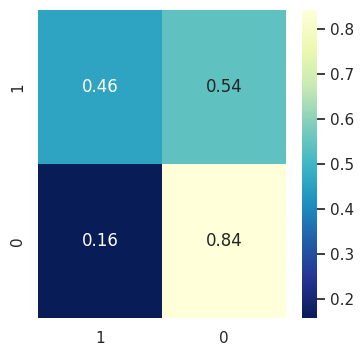

In [60]:
from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression(C=0.01, random_state=1, solver='lbfgs', multi_class='ovr')
lr1.fit(X1_train_pca, y1_train_os)
lr1_predict = lr1.predict(X1_test_pca)
model_evaluation(lr1, X1_train_pca, y1_train_os, y1_test_os, lr1_predict)

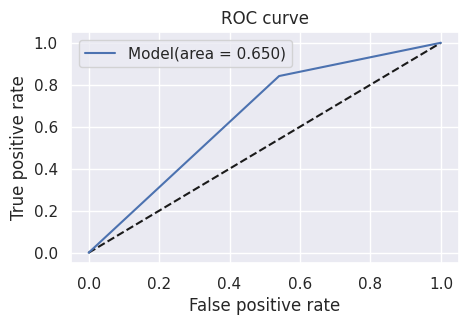

In [61]:
plot_roc(y1_test_os, lr1_predict)

*Train-test combination two - Multiple imputation and PCA*

LogisticRegression(C=0.01, multi_class='ovr', random_state=1) 

Train set Accuracy:  76.0 %
Test set Accuracy:  77.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

         0.0       0.71      0.81      0.76     33162
         1.0       0.83      0.74      0.79     42156

    accuracy                           0.77     75318
   macro avg       0.77      0.78      0.77     75318
weighted avg       0.78      0.77      0.77     75318

--------------------------------------------------

Confusion Matrix: 



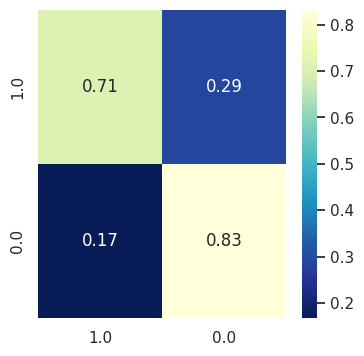

In [62]:
lr2 = LogisticRegression(C=0.01, random_state=1, solver='lbfgs', multi_class='ovr')
lr2.fit(X2_train_pca, y2_train_os)
lr2_predict = lr2.predict(X2_test_pca)
model_evaluation(lr2, X2_train_pca, y2_train_os, y2_test_os, lr2_predict)

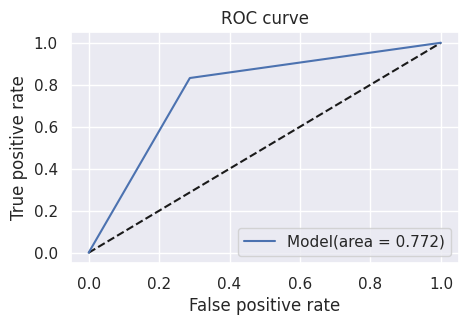

In [63]:
plot_roc(y2_test_os, lr2_predict)

*Train-test combination three - Regression imputation and L1 regularization*

LogisticRegression(C=0.01, multi_class='ovr', random_state=1) 

Train set Accuracy:  65.0 %
Test set Accuracy:  66.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.47      0.75      0.58     23677
           1       0.84      0.61      0.71     51641

    accuracy                           0.66     75318
   macro avg       0.66      0.68      0.64     75318
weighted avg       0.72      0.66      0.67     75318

--------------------------------------------------

Confusion Matrix: 



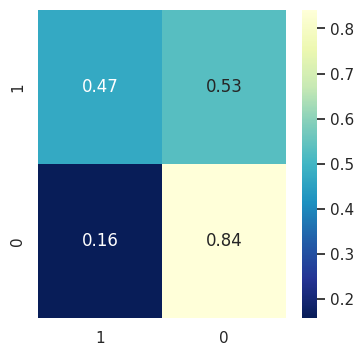

In [64]:
lr3 = LogisticRegression(C=0.01, random_state=1, solver='lbfgs', multi_class='ovr')
lr3.fit(X1_train_L1, y1_train_os)
lr3_predict = lr3.predict(X1_test_L1)
model_evaluation(lr3, X1_train_L1, y1_train_os, y1_test_os, lr3_predict)

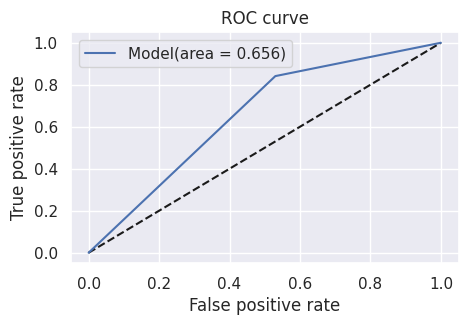

In [65]:
plot_roc(y1_test_os, lr3_predict)

*Train-test combination four - Multiple imputation and L1 regularization*

LogisticRegression(C=0.01, multi_class='ovr', random_state=1) 

Train set Accuracy:  82.0 %
Test set Accuracy:  74.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

         0.0       0.65      0.80      0.71     30640
         1.0       0.83      0.70      0.76     44678

    accuracy                           0.74     75318
   macro avg       0.74      0.75      0.74     75318
weighted avg       0.76      0.74      0.74     75318

--------------------------------------------------

Confusion Matrix: 



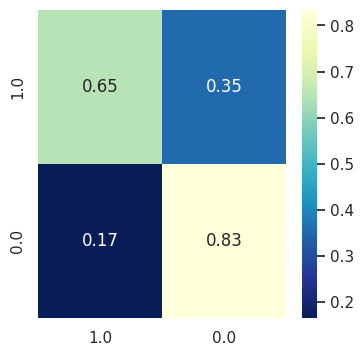

In [66]:
lr4 = LogisticRegression(C=0.01, random_state=1, solver='lbfgs', multi_class='ovr')
lr4.fit(X2_train_L1, y2_train_os)
lr4_predict = lr4.predict(X2_test_L1)
model_evaluation(lr4, X2_train_L1, y2_train_os, y2_test_os, lr4_predict)

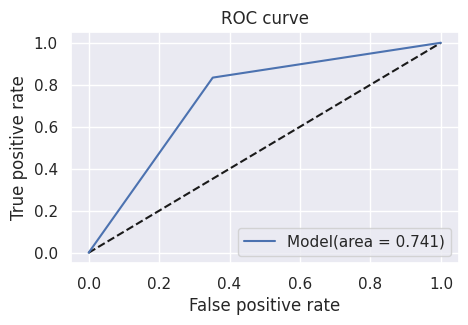

In [67]:
plot_roc(y2_test_os, lr4_predict)

Based on the prediction results of the above four combinations, the **second combination (regression imputation and PCA) has the highest AUC**, so I will continue to fine-tune the parameters of the second combination

*Fine-tune the hyperparameters for Train-test combination two - Multiple imputation and PCA*

Based on the prediction results of the four combinations mentioned above, I then use grid search and 5 fold cross validation based on combination two for parameter adjustment and prediction. 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm

GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='ovr', random_state=1),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                               1000.0],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc') 

Train set Accuracy:  80.0 %
Test set Accuracy:  77.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

         0.0       0.71      0.81      0.76     33162
         1.0       0.83      0.74      0.79     42156

    accuracy                           0.77     75318
   macro avg       0.77      0.78      0.77     75318
weighted avg       0.78      0.77      0.77     75318

--------------------------------------------------

Confusion Matrix: 



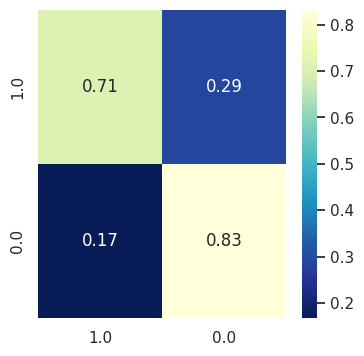

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(random_state=1, multi_class='ovr')

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid = {'C': param_range, 'solver': param_solver}

grid_lr = GridSearchCV(estimator=lr,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=5)

grid_lr.fit(X2_train_pca, y2_train_os)
grid_lr_predict = grid_lr.predict(X2_test_pca)

model_evaluation(grid_lr, X2_train_pca, y2_train_os, y2_test_os, grid_lr_predict)

In [90]:
print('The best performance are：%0.3f' % grid_lr.best_score_)
best_parameters = grid_lr.best_estimator_.get_params()
print('The best hyperparamet：\n', best_parameters)

The best performance are：0.796
The best hyperparamet：
 {'C': 1000.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


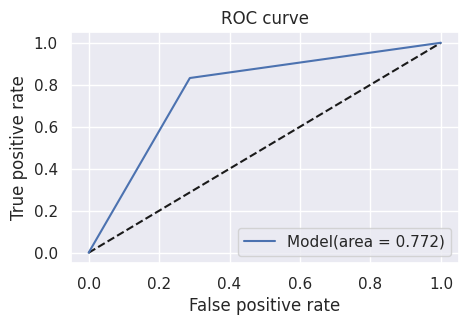

In [91]:
plot_roc(y2_test_os, grid_lr_predict)

Based on the above prediction, the final prediction preformance for logistic regression model is:

*   Model: Logistic regression
*   Train set Accuracy:  80.0%
*   Test set Accuracy:  77.0%
*   Precision:  0.78
*   Recall:  0.77
*   F1-score:  0.77
*   Area under curve:  0.772
*   Best training-testing combination: Multiple imputation and PCA feature selection method

### Model 2 Random Forest


A random forest produces good predictions that can be understood easily. It can handle large datasets efficiently. The random forest algorithm provides a higher level of accuracy in predicting outcomes over the decision tree algorithm. 

*Train-test combination one - Regression imputation and PCA*

RandomForestClassifier(max_depth=3, random_state=1) 

Train set Accuracy:  65.0 %
Test set Accuracy:  65.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.49      0.73      0.58     24997
           1       0.82      0.62      0.70     50321

    accuracy                           0.65     75318
   macro avg       0.65      0.67      0.64     75318
weighted avg       0.71      0.65      0.66     75318

--------------------------------------------------

Confusion Matrix: 



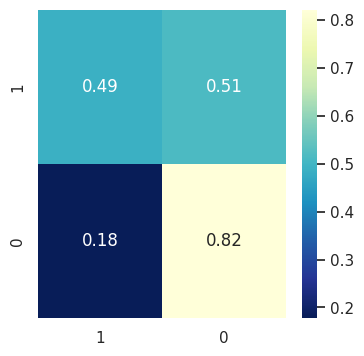

In [98]:
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(max_depth=3, random_state=1)
rf1.fit(X1_train_pca,y1_train_os)
rf1_predict = rf1.predict(X1_test_pca)

model_evaluation(rf1, X1_train_pca, y1_train_os, y1_test_os, rf1_predict)

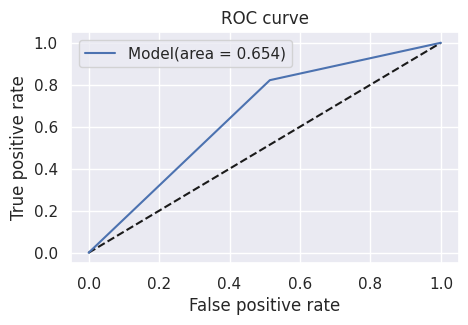

In [71]:
plot_roc(y1_test_os, rf1_predict)

*Train-test combination two - Multiple imputation and PCA*

RandomForestClassifier(max_depth=3, random_state=1) 

Train set Accuracy:  74.0 %
Test set Accuracy:  77.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.68      0.82      0.75     31316
           1       0.85      0.73      0.79     44002

    accuracy                           0.77     75318
   macro avg       0.77      0.78      0.77     75318
weighted avg       0.78      0.77      0.77     75318

--------------------------------------------------

Confusion Matrix: 



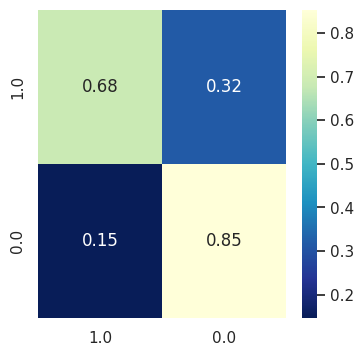

In [72]:
rf2 = RandomForestClassifier(max_depth=3, random_state=1)
rf2.fit(X2_train_pca,y1_train_os)
rf2_predict = rf2.predict(X2_test_pca)

model_evaluation(rf2, X2_train_pca, y2_train_os, y2_test_os, rf2_predict)

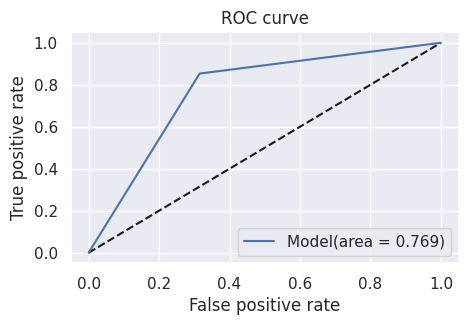

In [73]:
plot_roc(y2_test_os, rf2_predict)

*Train-test combination three - Regression imputation and L1 regularization*

RandomForestClassifier(max_depth=3, random_state=1) 

Train set Accuracy:  65.0 %
Test set Accuracy:  65.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.45      0.75      0.56     22427
           1       0.85      0.61      0.71     52891

    accuracy                           0.65     75318
   macro avg       0.65      0.68      0.63     75318
weighted avg       0.73      0.65      0.66     75318

--------------------------------------------------

Confusion Matrix: 



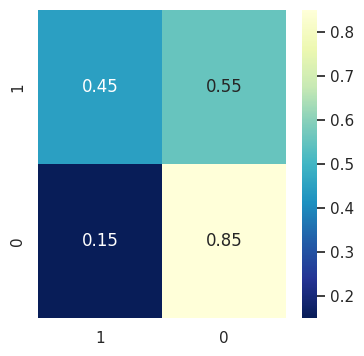

In [74]:
rf3 = RandomForestClassifier(max_depth=3, random_state=1)
rf3.fit(X1_train_L1,y1_train_os)
rf3_predict = rf3.predict(X1_test_L1)

model_evaluation(rf3, X1_train_L1, y1_train_os, y1_test_os, rf3_predict)

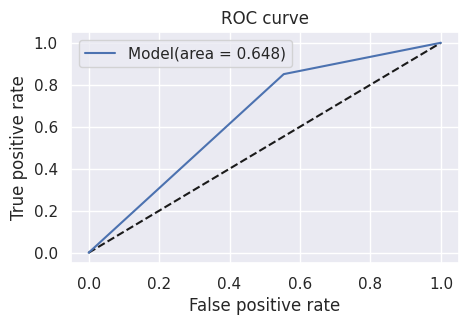

In [75]:
plot_roc(y1_test_os, rf3_predict)

*Train-test combination four - Multiple imputation and L1 regularization*

RandomForestClassifier(max_depth=3, random_state=1) 

Train set Accuracy:  80.0 %
Test set Accuracy:  76.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

         0.0       0.71      0.79      0.75     34099
         1.0       0.81      0.74      0.77     41219

    accuracy                           0.76     75318
   macro avg       0.76      0.76      0.76     75318
weighted avg       0.77      0.76      0.76     75318

--------------------------------------------------

Confusion Matrix: 



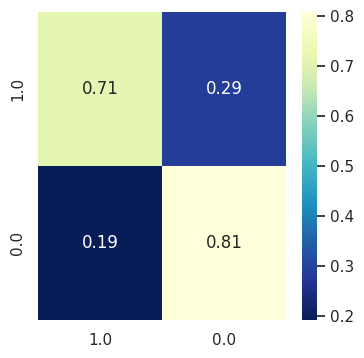

In [76]:
rf4 = RandomForestClassifier(max_depth=3, random_state=1)
rf4.fit(X2_train_L1,y2_train_os)
rf4_predict = rf4.predict(X2_test_L1)

model_evaluation(rf4, X2_train_L1, y2_train_os, y2_test_os, rf4_predict)

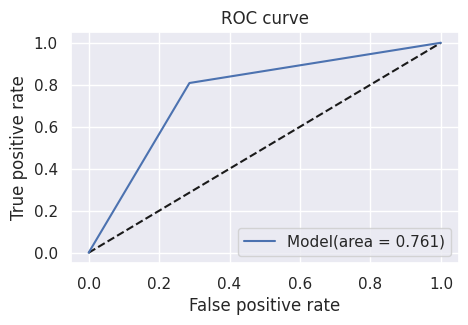

In [77]:
plot_roc(y2_test_os, rf4_predict)

Still, the **second combination (regression imputation and PCA) has the highest AUC**, so I will continue to fine-tune the parameters of the second combination. 

*Fine-tune the hyperparameters for Train-test combination two - Multiple imputation and PCA*

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [1, 3, 5]}, scoring='roc_auc') 

Train set Accuracy:  84.0 %
Test set Accuracy:  77.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

         0.0       0.68      0.83      0.75     30759
         1.0       0.86      0.73      0.79     44559

    accuracy                           0.77     75318
   macro avg       0.77      0.78      0.77     75318
weighted avg       0.79      0.77      0.77     75318

--------------------------------------------------

Confusion Matrix: 



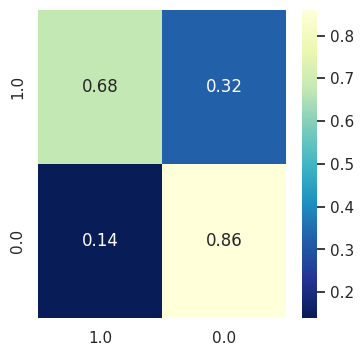

In [130]:
rf = RandomForestClassifier(random_state=1)

param_grid = {'max_depth': [1, 3, 5]}

grid_rf = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=5)

grid_rf.fit(X2_train_pca, y2_train_os)
grid_rf_predict = grid_rf.predict(X2_test_pca)

model_evaluation(grid_rf, X2_train_pca, y2_train_os, y2_test_os, grid_rf_predict)

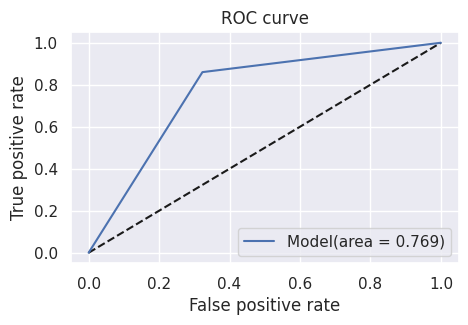

In [131]:
plot_roc(y2_test_os, grid_rf_predict)

Based on the above prediction, the final prediction preformance for random forest model is:

*   Model: Random forest
*   Train set Accuracy:  84.0%
*   Test set Accuracy:  77.0%
*   Precision:  0.79
*   Recall:  0.77
*   F1-score:  0.77
*   Area under curve:  0.769
*   Best training-testing combination: Multiple imputation and PCA feature selection method

### Model 3 Stochastic Gradient Descent

Stochastic gradient descent is an iterative method for optimizing an objective function with suitable smoothness properties. It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). **Especially in high-dimensional optimization problems this reduces the very high computational burden, achieving faster iterations in exchange for a lower convergence rate.**

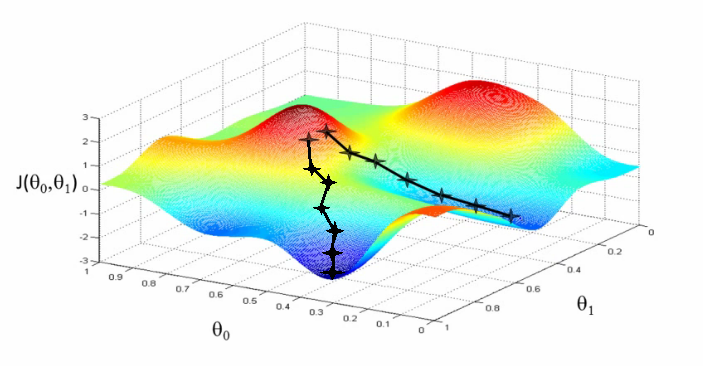

In [127]:
from PIL import Image
img3 = Image.open('gradient-descent.png')
img3.show()

*Train-test combination one - Regression imputation and PCA*

SGDClassifier() 

Train set Accuracy:  64.0 %
Test set Accuracy:  65.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.42      0.77      0.54     20798
           1       0.87      0.60      0.71     54520

    accuracy                           0.65     75318
   macro avg       0.65      0.68      0.63     75318
weighted avg       0.75      0.65      0.67     75318

--------------------------------------------------

Confusion Matrix: 



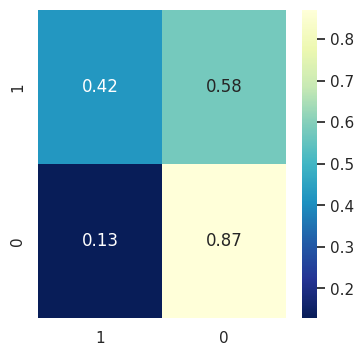

In [99]:
from sklearn.linear_model import SGDClassifier

SGD1 = SGDClassifier(max_iter = 1000)
SGD1.fit(X1_train_pca, y1_train_os)
SGD1_predict = SGD1.predict(X1_test_pca)

model_evaluation(SGD1, X1_train_pca, y1_train_os, y1_test_os, SGD1_predict)

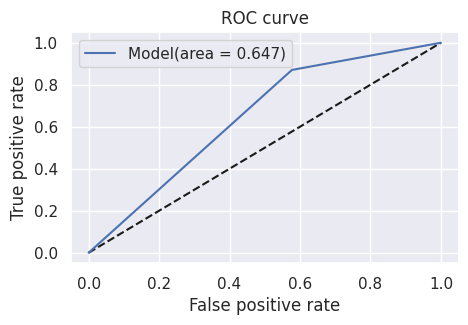

In [100]:
plot_roc(y1_test_os, SGD1_predict)

*Train-test combination two - Multiple imputation and PCA*

SGDClassifier() 

Train set Accuracy:  75.0 %
Test set Accuracy:  76.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

         0.0       0.65      0.84      0.73     29357
         1.0       0.87      0.72      0.79     45961

    accuracy                           0.76     75318
   macro avg       0.76      0.78      0.76     75318
weighted avg       0.79      0.76      0.77     75318

--------------------------------------------------

Confusion Matrix: 



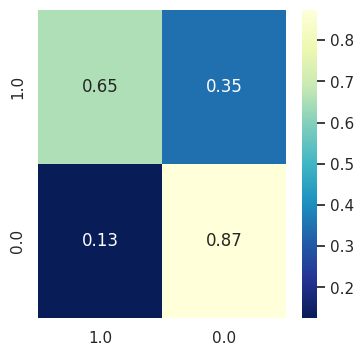

In [101]:
SGD2 = SGDClassifier(max_iter = 1000)
SGD2.fit(X2_train_pca,y2_train_os)
SGD2_predict = SGD2.predict(X2_test_pca)

model_evaluation(SGD2, X2_train_pca, y2_train_os, y2_test_os, SGD2_predict)

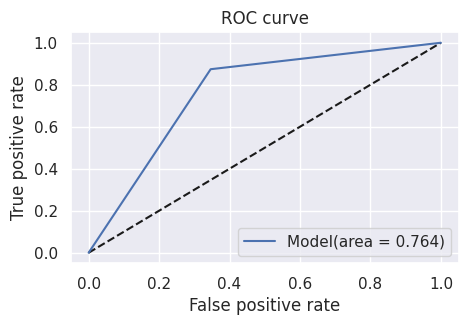

In [102]:
plot_roc(y2_test_os, SGD2_predict)

*Train-test combination three - Regression imputation and L1*

SGDClassifier() 

Train set Accuracy:  64.0 %
Test set Accuracy:  64.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.40      0.77      0.53     19562
           1       0.88      0.60      0.71     55756

    accuracy                           0.64     75318
   macro avg       0.64      0.68      0.62     75318
weighted avg       0.76      0.64      0.66     75318

--------------------------------------------------

Confusion Matrix: 



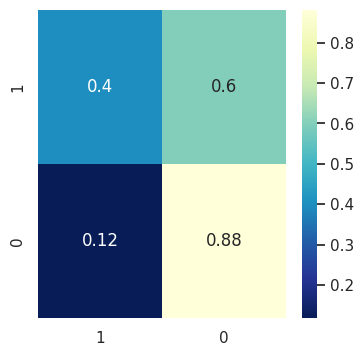

In [103]:
SGD3 = SGDClassifier(max_iter = 1000)
SGD3.fit(X1_train_L1,y1_train_os)
SGD3_predict = SGD3.predict(X1_test_L1)

model_evaluation(SGD3, X1_train_L1, y1_train_os, y1_test_os, SGD3_predict)

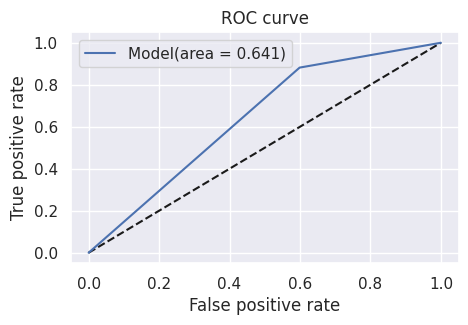

In [104]:
plot_roc(y1_test_os, SGD3_predict)

*Train-test combination four - Multiple imputation and L1*

SGDClassifier() 

Train set Accuracy:  82.0 %
Test set Accuracy:  74.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

         0.0       0.65      0.80      0.72     30691
         1.0       0.84      0.71      0.77     44627

    accuracy                           0.74     75318
   macro avg       0.74      0.75      0.74     75318
weighted avg       0.76      0.74      0.75     75318

--------------------------------------------------

Confusion Matrix: 



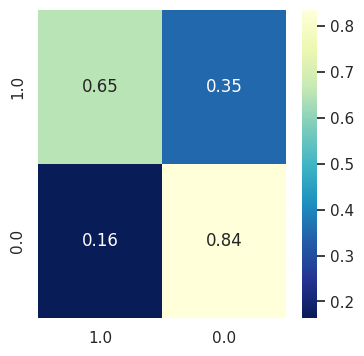

In [107]:
SGD4 = SGDClassifier(max_iter = 1000)
SGD4.fit(X2_train_L1,y2_train_os)
SGD4_predict = SGD4.predict(X2_test_L1)

model_evaluation(SGD4, X2_train_L1, y2_train_os, y2_test_os, SGD4_predict)

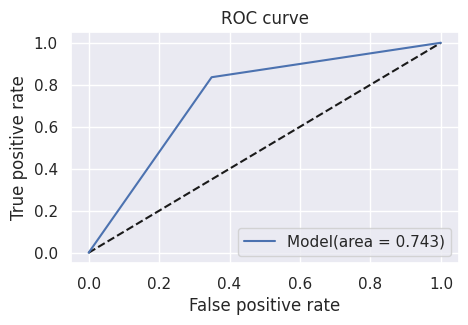

In [108]:
plot_roc(y2_test_os, SGD4_predict)

*Fine-tune the hyperparameters for Train-test combination two - Multiple imputation and PCA*

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=1),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'modified_huber'],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc') 

Train set Accuracy:  80.0 %
Test set Accuracy:  77.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

         0.0       0.71      0.81      0.76     33159
         1.0       0.83      0.74      0.78     42159

    accuracy                           0.77     75318
   macro avg       0.77      0.78      0.77     75318
weighted avg       0.78      0.77      0.77     75318

--------------------------------------------------

Confusion Matrix: 



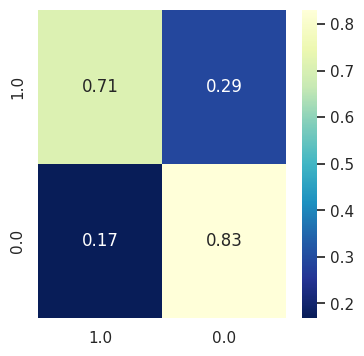

In [117]:
SGD = SGDClassifier(random_state=1)

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l1', 'l2']
}

grid_SGD = GridSearchCV(estimator=SGD,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=5)

grid_SGD.fit(X2_train_pca, y2_train_os)
grid_SGD_predict = grid_SGD.predict(X2_test_pca)

model_evaluation(grid_SGD, X2_train_pca, y2_train_os, y2_test_os, grid_SGD_predict)

In [119]:
print('The best performance are：%0.3f' % grid_SGD.best_score_)
best_parameters = grid_SGD.best_estimator_.get_params()
print('The best hyperparamet：\n', best_parameters)

The best performance are：0.797
The best hyperparamet：
 {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


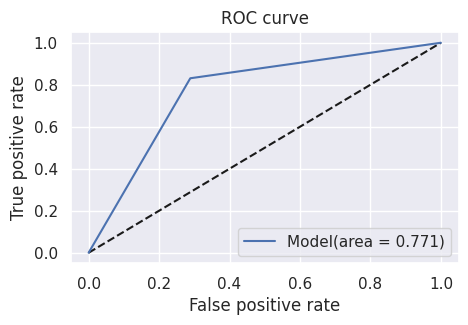

In [118]:
plot_roc(y2_test_os, grid_SGD_predict)

Based on the above prediction, the final prediction preformance for stochastic gradient descent model is:

*   Model: Stochastic gradient descent
*   Train set Accuracy:  80.0%
*   Test set Accuracy:  77.0%
*   Precision:  0.76
*   Recall:  0.74
*   F1-score:  0.75
*   Area under curve:  0.771
*   Best training-testing combination: Multiple imputation and PCA feature selection method

### Model 4 XGBoost

*Train-test combination one - Regression imputation and PCA*

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) 

Train set Accuracy:  66.0 %
Test set Accuracy:  65.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.47      0.74      0.57     23650
           1    

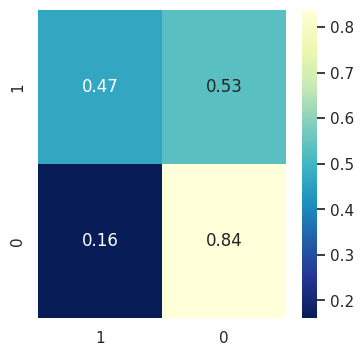

In [109]:
from xgboost import XGBClassifier

XGB1 = XGBClassifier(max_depth=5,
                      learning_rate = 0.02)

XGB1.fit(X1_train_pca,y1_train_os)
XGB1_predict = XGB1.predict(X1_test_pca)

model_evaluation(XGB1, X1_train_pca, y1_train_os, y1_test_os, XGB1_predict)

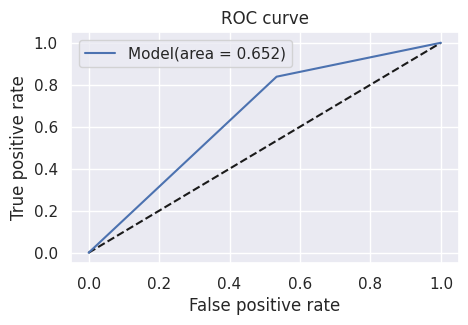

In [110]:
plot_roc(y1_test_os, XGB1_predict)

*Train-test combination two - Multiple imputation and PCA*

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) 

Train set Accuracy:  78.0 %
Test set Accuracy:  76.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.66      0.83      0.73     29949
           1    

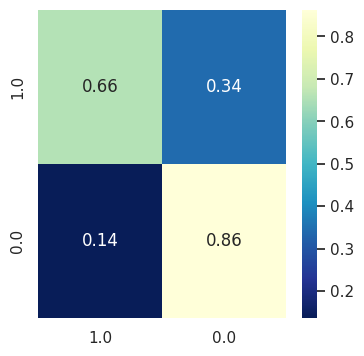

In [111]:
from xgboost import XGBClassifier

XGB2 = XGBClassifier(max_depth=5,
                      learning_rate = 0.02)

XGB2.fit(X2_train_pca,y2_train_os)
XGB2_predict = XGB2.predict(X2_test_pca)

model_evaluation(XGB2, X2_train_pca, y2_train_os, y2_test_os, XGB2_predict)

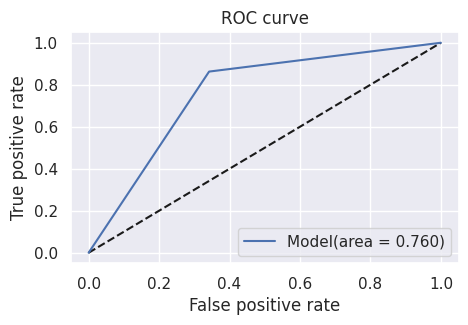

In [112]:
plot_roc(y2_test_os, XGB2_predict)

*Train-test combination three - Regression imputation and L1*

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) 

Train set Accuracy:  66.0 %
Test set Accuracy:  65.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.46      0.75      0.57     22937
           1    

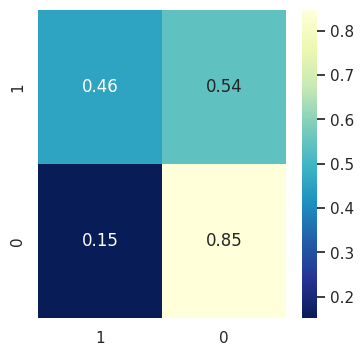

In [113]:
from xgboost import XGBClassifier

XGB3 = XGBClassifier(max_depth=5,
                      learning_rate = 0.02)

XGB3.fit(X1_train_L1,y1_train_os)
XGB3_predict = XGB3.predict(X1_test_L1)

model_evaluation(XGB3, X1_train_L1, y1_train_os, y1_test_os, XGB3_predict)

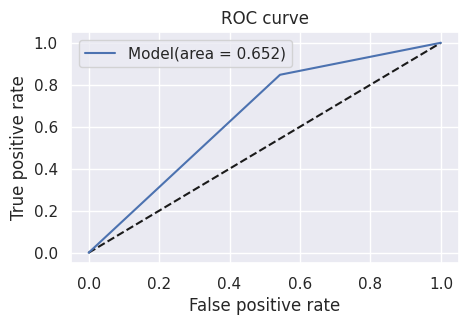

In [114]:
plot_roc(y1_test_os, XGB3_predict)

*Train-test combination four - Multiple imputation and L1*

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) 

Train set Accuracy:  82.0 %
Test set Accuracy:  75.0 %

--------------------------------------------------

Model Report: 
               precision    recall  f1-score   support

           0       0.68      0.80      0.73     32100
           1    

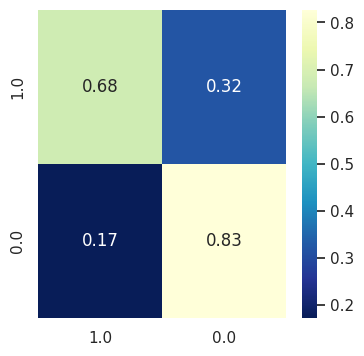

In [115]:
from xgboost import XGBClassifier

XGB4 = XGBClassifier(max_depth=5,
                      learning_rate = 0.02)

XGB4.fit(X2_train_L1,y2_train_os)
XGB4_predict = XGB4.predict(X2_test_L1)

model_evaluation(XGB4, X2_train_L1, y2_train_os, y2_test_os, XGB4_predict)

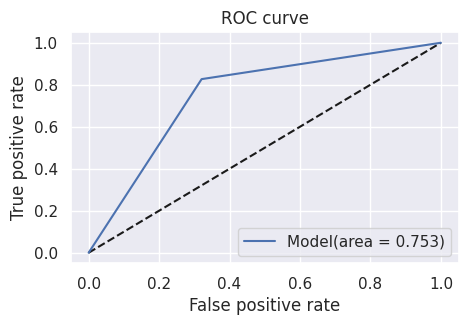

In [116]:
plot_roc(y2_test_os, XGB4_predict)

Fine-tune the hyperparameters

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max

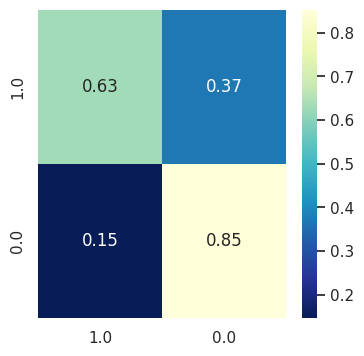

In [132]:
XGB = XGBClassifier(random_state=1)

param_grid = {
    'learning_rate': [0.01, 0.02, 0.2],
    'max_depth': [3, 5]
}

grid_XGB = GridSearchCV(estimator=XGB,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=5)

grid_XGB.fit(X2_train_pca, y2_train_os)
grid_XGB_predict = grid_XGB.predict(X2_test_pca)

model_evaluation(grid_XGB, X2_train_pca, y2_train_os, y2_test_os, grid_XGB_predict)

In [133]:
print('The best performance are：%0.3f' % grid_XGB.best_score_)
best_parameters = grid_XGB.best_estimator_.get_params()
print('The best hyperparamet：\n', best_parameters)

The best performance are：0.911
The best hyperparamet：
 {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 1, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


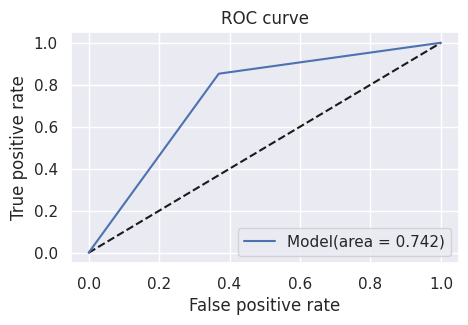

In [134]:
plot_roc(y2_test_os, grid_XGB_predict)

Based on the above prediction, the final prediction preformance for XGBoost model is:

*   Model: XGBoost
*   Train set Accuracy:  92.0%
*   Test set Accuracy:  74.0%
*   Precision:  0.77
*   Recall:  0.74
*   F1-score:  0.74
*   Area under curve:  0.742
*   Best training-testing combination: Multiple imputation and PCA feature selection method

## Conclusion

In [2]:
Prediction_preformance = pd.DataFrame({
    'Model': ['Logistic regression', 'Random Forest', 'Stochastic Gradient Descent', 'XGBoost'],
    'Train set Accuracy': [0.80, 0.84, 0.80, 0.92],
    'Test set Accuracy': [0.77, 0.77, 0.77, 0.74],
    'Precision': [0.78, 0.79, 0.76, 0.77],
    'Recall:': [0.77, 0.77, 0.74, 0.74],
    'F1-score': [0.77, 0.75, 0.74, 0.74],
    'AUC': [0.772, 0.769, 0.771, 0.742]})

In [3]:
Prediction_preformance

,Model,Train set Accuracy,Test set Accuracy,Precision,Recall:,F1-score,AUC
0,Logistic regression,0.80,0.77,0.78,0.77,0.77,0.772
1,Random Forest,0.84,0.77,0.79,0.77,0.75,0.769
2,Stochastic Gradient Descent,0.80,0.77,0.76,0.74,0.74,0.771
3,XGBoost,0.92,0.74,0.77,0.74,0.74,0.742


Based on the above analysis results, the model with the best prediction performance is the **logistic regression model**, with an test accuracy of 77% and an AUC of 0.772, ranking the highest. Among these models, the data combination with the best unified performance is multiple imputation and PCA feature selection method. And the most important feature in the prediction is **var4**. 

## Reference

[1] https://towardsdatascience.com/https-medium-com-reina-wang-tw-stochastic-gradient-descent-with-restarts-5f511975163</br>
[2] https://metamug.com/article/groovy/stochastic-gradient-descent-tutorial-code-by-andrew-ng.html</br>
[3] https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer</br>
[4] https://www.kaggle.com/competitions/tabular-playground-series-jun-2022/discussion/331227</br>
[5] https://towardsdatascience.com/handling-missing-data-like-a-pro-part-3-model-based-multiple-imputation-methods-bdfe85f93087</br>
[6] https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression/notebook